In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc
from matplotlib import cm
import seaborn.apionly as sns
from scipy import interpolate
from scipy.optimize import minimize

%matplotlib inline

In [2]:
rc('font', size=8)
rc('font', family='Arial')
rc('axes', linewidth=1)
rc('xtick.major', width=0.5, size=1.5)
rc('ytick.major', width=0.5, size=1.5)

rc('mathtext', default='regular')

In [3]:
colors = ['#F9ED69', '#F08A5D', '#B83B5E', '#6A2C70']
colors.reverse()

# Figure 3

In [4]:
# load in the experimental data
df = pd.read_csv('../systematic_grid_data/grid.results.csv')

In [5]:
duplicated = df.meas_id[df.duplicated('meas_id')]
clean_df = df
clean_df.head(10)
for ind in duplicated.tolist():
    means = clean_df[['NA','MA','BA','TA']][df.meas_id == ind].mean()
    first_loc = clean_df.index[df.meas_id == ind][0]
    clean_df.loc[first_loc, 'NA':'TA'] = means.values
    
clean_df = clean_df.drop(df.index[duplicated.index.tolist()])
clean_df = clean_df.reset_index(drop=True).sort_values('meas_id')

In [6]:
clean_df['stack_MA'] = clean_df.MA + clean_df.NA
clean_df['stack_BA'] = clean_df.MA + clean_df.NA + clean_df.BA
clean_df['stack_TA'] = clean_df.MA + clean_df.NA + clean_df.BA + clean_df.TA

In [7]:
from scipy.optimize import minimize

def guide(x, a, b, c):
    return a * np.exp(-(b*x)) + c

def mse(k, x, y):
    y_est = guide(x, k[0], k[1], k[2])
    mean_sq_err = np.sum((y_est - y)**2) / len(y)
    
    return mean_sq_err

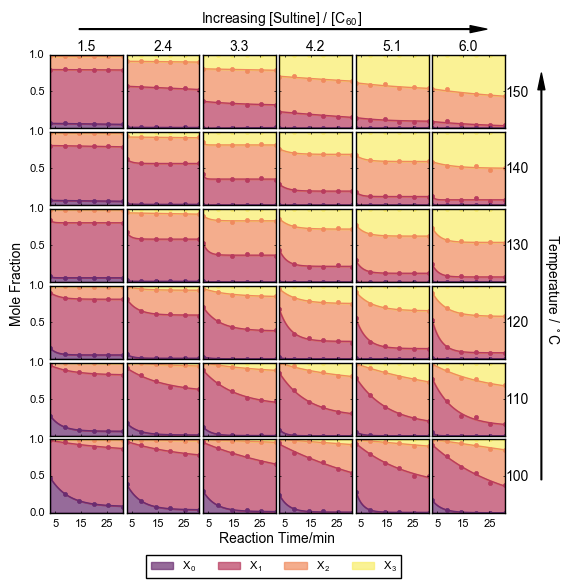

In [8]:
fig, axes = plt.subplots(figsize=(5,5), nrows=6, ncols=6, sharex=True)

colors = colors
excess = clean_df.excess.unique()
temp = list(reversed(clean_df.temperature.unique()))
keys = ['NA','stack_MA','stack_BA','stack_TA']
alpha = 0.7

for i in range(6):
    for j in range(6):
        to_plot = clean_df[(clean_df.excess == excess[j]) & (clean_df.temperature == temp[i])]
        
        plot_fit = pd.DataFrame()
        plot_fit['time'] = np.linspace(to_plot.time.min(), to_plot.time.max(), 101)

        keys = ['NA','stack_MA','stack_BA','stack_TA']

        x0 = [0.1, 0, 0]
        for key in keys:
            results = minimize(mse, x0, args=(to_plot.time, to_plot[key]), options={'gtol': 1e-6})
            plot_fit[key] = guide(plot_fit.time, results.x[0], results.x[1], results.x[2])
        
        axes[i,j].fill_between(plot_fit.time, 0, plot_fit.NA, color=colors[0], alpha=alpha)
        axes[i,j].fill_between(plot_fit.time, plot_fit.NA, plot_fit.stack_MA, color=colors[1], alpha=alpha)
        axes[i,j].fill_between(plot_fit.time, plot_fit.stack_MA, plot_fit.stack_BA, color=colors[2], alpha=alpha)
        axes[i,j].fill_between(plot_fit.time, plot_fit.stack_BA, plot_fit.stack_TA, color=colors[3], alpha=alpha)
        
        legend = plt.legend(labels=(r'X$_0$','X$_1$','X$_2$','X$_3$'),
                            bbox_to_anchor=(-0.55,-0.6,0.2,0.1),ncol=4,fontsize=8)
        legend.get_frame().set_linewidth(1)
        
        for key, color in zip(list(reversed(keys)), list(reversed(colors))):
            axes[i,j].plot(to_plot.time, to_plot[key], 'o', mec=color, color=color, markersize=3)
            axes[i,j].plot(plot_fit.time, plot_fit[key], color=color, lw=1)
        
        axes[i,j].set_yticks([0.5, 1])
        axes[i,j].set_ylim(0,1)
        if j > 0:
            axes[i,j].set_yticklabels([])
    


axes[-1,0].set_yticks([0, 0.5, 1])
axes[0,0].set_xlim((to_plot.time.min(),to_plot.time.max()))
fig.text(0.52, 0, r'Reaction Time/min', ha='center', va='center', fontsize=10)
fig.text(0, 0.51, r'Mole Fraction', ha='center', va='center', rotation='vertical', fontsize=10)

for i in range(6):
    axes[0,i].text(0.5, 1.11, str(excess[i]), transform=axes[0,i].transAxes, 
                   va='center', ha='center', fontsize=10)
    axes[i,5].text(1.17, 0.49, str(int(temp[i])), transform=axes[i,5].transAxes, 
                   va='center', ha='center', fontsize=10)

axes[0,0].set_xticks([5, 15, 25])

fig.text(0.53, 1.04, r'Increasing [Sultine] / [C$_{60}$]', ha='center', va='center', fontsize=10)
fig.text(1.07, 0.5, r'Temperature / $^\circ$C', ha='center', va='center', rotation='270', fontsize=10)
axes[0,0].annotate('', xy=(6, 1.35), xytext=(0.4, 1.35), xycoords='axes fraction', textcoords='axes fraction',
                   arrowprops=dict(facecolor='black', width=0.5, headwidth=5))
axes[5,5].annotate('', xy=(1.5, 6), xytext=(1.5, 0.45), xycoords='axes fraction', textcoords='axes fraction',
                   arrowprops=dict(facecolor='black', width=0.5, headwidth=5))
            
fig.tight_layout()
fig.subplots_adjust(wspace=0.05,hspace=0.05)
fig.savefig('/home/barnaby/Dropbox/PhD/ReactorPaper/figures/figure3_2.pdf', bbox_inches='tight')